# Multiple Type Experiment

In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms_multiple import *
from radar_plot import *

In [2]:
#np.random.choice(size=5, a=[1.,2.], p=[1/2, 1/2])
1+np.random.poisson(size=5,lam = 1.5)

array([3, 5, 3, 2, 2])

In [4]:
data = []
num_types = 5
num_resources = 3
weights = np.asarray([[1, 2, 3], [1, 3, 2], [4, 1, 5], [1, 2, .5], [3, 7, 5]])
sum_of_rows = weights.sum(axis=1)
weights = weights / sum_of_rows[:, np.newaxis]

algo_list = {
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/3),
             'MPC': hope_online,}
             

num_algo = len(algo_list)

num_iterations = 100

act_mean = np.asarray([1.5, 2.5, 3.5, 4.5, 5.5])
mean_size = act_mean
stdev_size = mean_size


In [5]:

num_groups = np.logspace(2, 10, base=1.5, num=30).astype(int)

for n in tqdm(num_groups):
    n = int(n) + 5
    print('Num Locations: ' + str(n))
    # pected_size = mean_size
    budget = [np.sum(act_mean)*n, np.sum(act_mean)*n, np.sum(act_mean)*n]
    
    mean = np.array([mean_size,]*n)
    stdev = mean

    alloc_diff = np.zeros((len(algo_list), num_iterations, n, num_types, num_resources)) 
    
    for i in range(num_iterations):
        # size = np.random.choice(size=(n, num_types), a=[1.,2.], p=[1/2, 1/2])
        # size = 1+np.maximum(0, np.random.normal(size=(n, num_types), loc = mean_size-1, scale = .2))
        size = 1 + np.random.poisson(size = (n, num_types), lam = mean_size - 1)
        # print('Size: ' + str(size))
        total_num_types = np.sum(size, axis=0)
        
        prob, solver = generate_cvxpy_solve(num_types, num_resources)

        
        opt = offline_opt(budget, size, weights, solver)
        
        index = 0
        for algo in algo_list:
            
        
            sol, waste = algo_list[algo](budget, size, mean, stdev, weights, solver)
            
            if np.around(np.sum(waste), 3) < 0:
                print(f'Error with: {algo} and waste: {waste}')
            envy = 0
            for k in range(num_types):
                for t in range(n):
                    envy = max(envy, np.abs(np.dot(weights[k, :], opt[t, k, :] - sol[t, k, :])))
            alloc_diff[index, i, :, :, :] = opt - sol
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Envy', 'Value': envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'L1', 'Value': np.sum(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Linf', 'Value': np.max(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Waste', 'Value': np.sum(waste)}
            data.append(data_dict)
            index += 1

    index = 0
    for algo in algo_list:
        ex_ante_envy = 0
        for k in range(num_types):
            for t in range(n):
                # print(alloc_diff.shape)
                avg_diff = [np.abs(np.dot(weights[k, :], alloc_diff[index, r, t, k, :])) for r in range(num_iterations)]
                ex_ante_envy = max(ex_ante_envy, np.mean(avg_diff))
        data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Ex-Ante Envy', 'Value': ex_ante_envy}
        data.append(data_dict)
        index += 1

  0%|          | 0/30 [00:00<?, ?it/s]

Num Locations: 7
Num Locations: 7
Num Locations: 7
Num Locations: 8
Num Locations: 8
Num Locations: 8
Num Locations: 9
Num Locations: 9
Num Locations: 10
Num Locations: 11
Num Locations: 11
Num Locations: 12
Num Locations: 13
Num Locations: 14
Num Locations: 15
Num Locations: 17
Num Locations: 18
Num Locations: 20
Num Locations: 21
Num Locations: 23
Num Locations: 26
Num Locations: 28
Num Locations: 31
Num Locations: 34
Sizes!
[ 31.  54.  74.  97. 115.]
Weights!
[[0.16666667 0.33333333 0.5       ]
 [0.16666667 0.5        0.33333333]
 [0.4        0.1        0.5       ]
 [0.28571429 0.57142857 0.14285714]
 [0.2        0.46666667 0.33333333]]
Budget!
[346.51497 369.23783 391.1909 ]
Solve failed retyring verbose
Num Locations: 37
Num Locations: 41
Num Locations: 46
Num Locations: 51
Num Locations: 56
Num Locations: 62


In [8]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data/multi_poisson_simple.csv', index=False)
df = pd.read_csv('./data/multi_poisson_simple.csv')

In [ ]:
df.columns

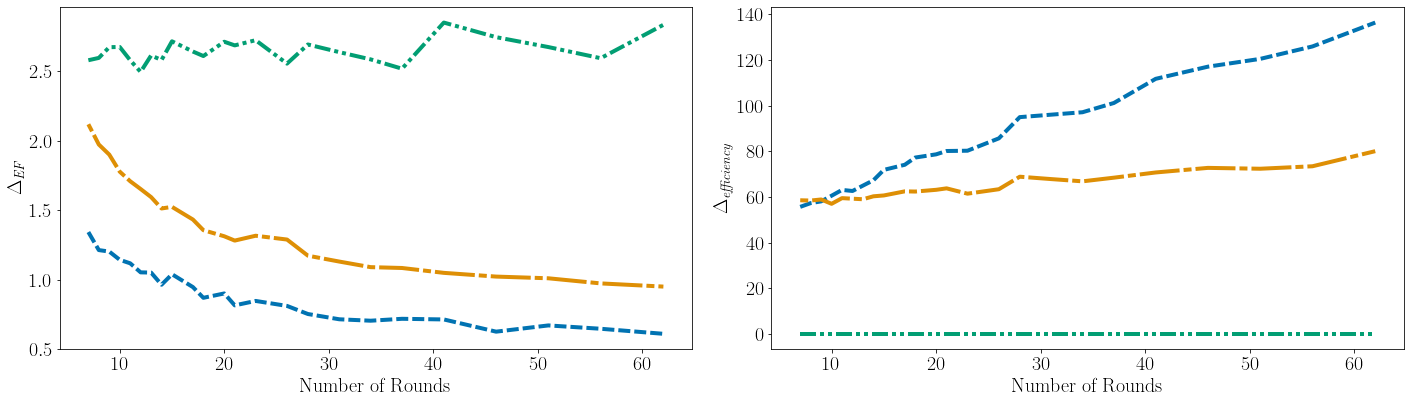

In [25]:

df.columns
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'fixed_threshold': 'Fixed Threshold', 'hope_guardrail_13': 'Guarded Hope $L_T = T^{-1/3}$', 'hope_guardrail_12': 'Guarded Hope $L_T = T^{-1/2}$'}))
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'Hope Guardrail $L_T = 1/2$': 'Guarded Hope $L_T = T^{-1/2}$', 'Hope Guardrail $L_T = 1/3$': 'Guarded Hope $L_T = T^{-1/3}$'}))



plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,2, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Linf'], ax = axs[0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)





axs[0].get_legend().remove()
axs[0].set_ylabel('$\Delta_{\it EF}$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\Delta_{\it efficiency}$')
axs[1].set_xlabel('Number of Rounds')
axs[1].get_legend().remove()



# axs[2].legend(ncol = 1, loc= 'upper right')




plt.show()
fg.savefig('./figures/synthetic_multi_simple.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)

In [23]:
def export_legend(legend, filename="LABEL_ONLY.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)


In [26]:
df['Algorithm']

0        Guarded Hope $L_T = T^{-1/2}$
1        Guarded Hope $L_T = T^{-1/2}$
2        Guarded Hope $L_T = T^{-1/2}$
3        Guarded Hope $L_T = T^{-1/2}$
4        Guarded Hope $L_T = T^{-1/3}$
                     ...              
36085                              MPC
36086                              MPC
36087    Guarded Hope $L_T = T^{-1/2}$
36088    Guarded Hope $L_T = T^{-1/3}$
36089                              MPC
Name: Algorithm, Length: 36090, dtype: object

In [13]:
legend = axs[1].legend(ncol = 5, loc= 'lower center', bbox_to_anchor=(-1, -.3, 0.5, 0.5))
print(len(legend.get_lines()))
[legend.get_lines()[i].set_linewidth(3) for i in range(len(legend.get_lines()))]

export_legend(legend)

3


### Group by Group Difference

In [ ]:
fair_data = []
expost_data = []


algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/3),
             'Hope Online': hope_online,
             'Hope Full': hope_full}    




num_iterations = 200
n = 500


budget = [np.sum(act_mean)*n, np.sum(act_mean)*n, np.sum(act_mean)*n]

mean = np.array([mean_size,]*n)
stdev = mean


alloc_diff = np.zeros((len(algo_list), num_iterations, n, num_types, num_resources)) 


for i in tqdm(range(num_iterations)):

    # print(mean)

    # size = np.random.choice(size=n, a=[1.,2.], p=[1/2, 1/2])
    size = 1 + np.random.poisson(size = (n, num_types), lam = mean_size - 1)# print('Size: ' + str(size))
    total_num_types = np.sum(size, axis=0)

    prob, solver = generate_cvxpy_solve(num_types, num_resources)


    # print(num_types, num_resources, budget.shape size.shape, )

    opt = offline_opt(budget, size, weights, solver)

    # print('opt: ' + str(opt))
    index = 0
    
    
    for algo in algo_list:
        # print(algo)
        sol, waste = algo_list[algo](budget, size, mean, stdev, weights, solver)
        prop_alloc = budget / np.sum(size)   
        
        
        true_envy = 0
        proportional = 0
        nsw = 0
        envy = 0
        
        nsw = np.prod([np.dot(weights[k, :], sol[t, k, :]) ** (size[t,k] / np.sum(size)) for t in range(n) for k in range(num_types)])
        proportional = np.max([max(np.dot(weights[k, :], prop_alloc) - np.matmul(sol[:,k,:], weights[k,:])) for k in range(num_types)])
        true_envy = np.max([max(np.matmul(sol[:,k2,:], weights[k1, :])) - min(np.matmul(sol[:,k1,:], weights[k1,:])) for k1 in range(num_types) for k2 in range(num_types)])
        envy = np.max([np.abs(np.dot(weights[k, :], opt[t, k, :] - sol[t, k, :])) for t in range(n) for k in range(num_types)])
                
        alloc_diff[index, i, :, :, :] = opt - sol
        index += 1
        
        fair_data.append({'Iteration':i, 'Algorithm':algo, 
                          '$\Delta_{\it efficiency}$': np.sum(waste) / n, 
                          '$\Delta_{\it Prop}$': proportional, 
                          '\textsc{NSW}'.encode('unicode_escape').decode('utf'): nsw,
                         '\textsc{Envy}'.encode('unicode_escape').decode('utf'): true_envy, 
                          '$\Delta_{\it EF}$': envy
                            })
            
for i in range(n):
    data.append({'Location': i, 'Algorithm':'Zero', 'Value': 0})
    
    
index = 0
for algo in algo_list:
    ex_ante_envy = np.max([np.mean([np.abs(np.dot(weights[k, :], alloc_diff[index, r, t, k, :])) for r in range(num_iterations)]) for t in range(n) for k in range(num_types)])
#     ex_ante_envy = (-1)*np.inf
#     # print(algo)
#     for k in range(num_types):
#         for t in range(n):
#             # print(alloc_diff.shape)
#             avg_diff = [np.abs(np.dot(weights[k, :], alloc_diff[index, r, t, k, :])) for r in range(num_iterations)]
#             # print(avg_diff)
#             ex_ante_envy = max(ex_ante_envy, np.mean(avg_diff))
    data_dict = {'Algorithm':algo, 'Iteration': 1, '$\Delta_{\it EF}^+$' : ex_ante_envy}
    fair_data.append(data_dict)
    index += 1

In [ ]:
fair_df = pd.DataFrame.from_records(fair_data)
fair_df.to_csv('./data/multi_poisson_fair.csv', index=False)
fair_df = pd.read_csv('./data/multi_poisson_fair.csv')

### Printing Fairness Metrics

In hindsight proportional as the same makes sense, as it will be achieved by people obtaining X_lower, which is the same for all the algorithms (and algorithms ensure they don't run out of budget....)

In [ ]:
# fair_df = pd.DataFrame.from_records(fair_data)

# print(fair_df.columns)
fair_df = fair_df.groupby(['Algorithm']).mean()
print(fair_df)

fair_df['$\Delta_{\it efficiency}$'] = (-1)*fair_df['$\Delta_{\it efficiency}$']
fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')] = (-1)*fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')]
fair_df['$\Delta_{\it EF}$'] = (-1)* fair_df['$\Delta_{\it EF}$']
fair_df['$\Delta_{\it Prop}$'] = (-1) * fair_df['$\Delta_{\it Prop}$']
fair_df['$\Delta_{\it EF}^+$'] = (-1)*fair_df['$\Delta_{\it EF}^+$']

In [ ]:
fair_df = normalize(fair_df).drop(['Iteration'], axis=1)
# fair_df = fair_df.drop('$\Delta_{\it Prop}$', axis=1)
print(fair_df)

In [ ]:
# number of variable


from math import pi
plt.style.use('PaperDoubleFig.mplstyle.txt')

plt.rc('text', usetex=True)




N = len(list(fair_df))
theta = radar_factory(N, frame='polygon')

spoke_labels = list(fair_df)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title('Comparison of Fairness Metrics',  position=(0.5, 1.1), ha='center')
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]

first_plot = { algo : algo_list[algo] for algo in ['Fixed Threshold', 'Hope Guardrail $L_T = 1/2$', 'Hope Guardrail $L_T = 1/3$']}
second_plot = { algo : algo_list[algo] for algo in ['Hope Guardrail $L_T = 1/2$', 'Hope Online', 'Hope Full']}


index = 0
for algo in first_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = sns.color_palette('colorblind', len(algo_list))[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/multi_synthetic_guardrail_radar.pdf')
plt.show()





fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])


dashesStyles = [
            [2,1,10,1],
            [1000,1],[8,2]]

color_list = [sns.color_palette("colorblind", len(algo_list))[1], sns.color_palette("colorblind", len(algo_list))[3], sns.color_palette("colorblind", len(algo_list))[4]]

index = 0
for algo in second_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = color_list[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/multi_synthetic_heuristic_radar.pdf')
plt.show()


